In [131]:
import time
from tqdm import tqdm
from multiprocessing import Pool
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FuncFormatter
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import obspy as op
from obspy import read,read_inventory, UTCDateTime, Stream, Trace
from obspy.clients.fdsn.client import Client
from obspy.signal.rotate import rotate_ne_rt
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel
from obspy.signal import PPSD

from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler,TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans,silhouette_score
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler

import shutil
import json
import glob
import os
import numpy as np
from itertools import combinations
import pandas as pd
from scipy.signal import spectrogram, detrend, resample,savgol_filter,decimate,hilbert
from scipy.stats import circmean, circstd

import pyarrow.feather as feather

import datetime

from sklearn.linear_model import LinearRegression,HuberRegressor,TheilSenRegressor

In [132]:
# ===========
# DIRECTORIES
# ===========

## ------------------------
## Directory with waveforms (SeisComP Data Structure)
## The basic directory and file layout is defined as:
## <SDSdir>/Year/NET/STA/CHAN.TYPE/NET.STA.LOC.CHAN.TYPE.YEAR.DAY

RF_DIR = '/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOUTH_AMERICA/DATA/BL.PLTB/'

## -----------------------
## Directory of the output (Figures and Feathers file)

PPSD_OUTPUT = '/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOUTH_AMERICA/OUTPUT/RF_ANALISYS/'

## ---------------
## MULTIPROCESSING

num_processes = 20

# Machine learning tools for the analysis of time series. 

Tavenard, R., Faouzi, J., Vandewiele, G., Divo, F., Androz, G., Holtz, C., Payne, M., Yurchak, R., Rußwurm, M., Kolar, K., & Woods, E. (2020). **Tslearn, a machine learning toolkit for time series data**. Journal of Machine Learning Research, 21(118), 1–6. http://jmlr.org/papers/v21/20-091.html


**tslearn** provides three methods for calculating barycenters for a given set of time series:

- Euclidean barycenter is simply the arithmetic mean for each individual point in time, minimizing the summed euclidean distance for each of them.
  
- DTW Barycenter Averaging (DBA) is an iteratively refined barycenter, starting out with a (potentially) bad candidate and improving it until convergence criteria are met. The optimization can be accomplished with (a) expectation-maximization and (b) stochastic subgradient descent. Empirically, the latter “is more stable and finds better solutions in shorter time”.

- Soft-DTW barycenter uses a differentiable loss function to iteratively find a barycenter.

![image.png](https://tslearn.readthedocs.io/en/stable/_images/sphx_glr_plot_barycenters_001.svg)

The analysis of seismic noise using Probabilistic Power Spectral Density (PPSD) is essential for assessing data quality from land-based seismic stations. Similar to the methodology applied to ocean-bottom sensors, PPSD processing involves calculating spectral densities over time to characterize noise patterns and identify artifacts. Each hour-long time series is divided into shorter segments (e.g., 1-minute windows with 50% overlap), which are then detrended, tapered, and processed using Welch’s method to estimate PSD. This approach minimizes long-period contamination and reduces spectral variance, ensuring reliable low-frequency estimates. The resulting PSDs are compiled into a probabilistic representation, highlighting dominant noise sources and potential distortions in the seismic records.

To classify noise patterns, an unsupervised machine learning approach—such as k-means clustering—is applied to the PSD data. The optimal number of clusters is determined using the Elbow method, while clustering quality is evaluated via the Silhouette coefficient, which measures cohesion and separation between groups. This allows for the identification of distinct spectral signatures, such as cultural noise (e.g., traffic, machinery), natural noise (e.g., microseisms, wind), or instrumental artifacts. Unlike ocean gliders, land stations often exhibit stronger anthropogenic noise, making clustering crucial for distinguishing between environmental and system-related disturbances.

The PPSD analysis provides a robust framework for assessing station performance without requiring pre-filtering. High-probability PSD peaks typically represent ambient noise, while low-probability outliers may indicate earthquakes, equipment malfunctions, or transient events. By grouping similar spectral signatures, the method helps flag problematic time windows, ensuring only high-quality data is used for further analysis. This is particularly valuable for long-term monitoring, where consistent data validation is necessary to maintain reliability.

Finally, the clustering results offer a generalized overview of noise behavior across different land stations, though physical interpretations of each cluster may require additional context. The approach is adaptable to various deployment conditions, making it suitable for networks with diverse sensor types and environmental settings. While the primary goal is to identify erratic patterns rather than assign physical meanings, the method enhances data quality control and supports more accurate seismic studies. Combining PPSD with clustering techniques thus provides a powerful tool for noise characterization in land-based seismic monitoring.

# Reading pre-estimated PRF (radial):

In [133]:
sta_list = sorted(list(set([i.split('/')[-2] for i in glob.glob(RF_DIR+'*_P_R.sac')])))

In [134]:
sta_list

['BL.PLTB']

In [135]:
RRF_files = sorted(glob.glob(RF_DIR+'*_P_R.sac'))

In [136]:
PRF_lst = []

for idx,prf_file in enumerate(RRF_files):
    prf = op.read(prf_file)

    dataR = [prf[0].data[int(5*prf[0].stats.sampling_rate):int(50*prf[0].stats.sampling_rate)]]
    dataR = dataR / np.abs(dataR).max()
    # Normalize the time series
    data_normR = TimeSeriesScalerMinMax(value_range=(-1, 1.0)).fit_transform(dataR)
    

    PRF_dic = {
                'filename': prf_file,
                'network': prf[0].stats.network,
                'station': prf[0].stats.station,
                'channel': prf[0].stats.channel,
                'baz': round(prf[0].stats.sac.baz),
                'sampling_rate': prf[0].stats.sampling_rate,
                'dataRnorm': [data_normR.flatten()],
                'dataR': [dataR.flatten()],
                'time': [prf[0].times()[int(5*prf[0].stats.sampling_rate):int(50*prf[0].stats.sampling_rate)]-10],
                'date':UTCDateTime(year=prf[0].stats.sac.nzyear,julday=prf[0].stats.sac.nzjday,hour=prf[0].stats.sac.nzhour,minute=prf[0].stats.sac.nzmin,second=prf[0].stats.sac.nzsec).datetime
                }
    PRF_lst.append(pd.DataFrame.from_dict(PRF_dic))

In [137]:
PRF_df = pd.concat(PRF_lst)

In [138]:
PRF_df

,filename,network,station,channel,baz,sampling_rate,dataRnorm,dataR,time,date
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,320,10.0,"[-0.7765470717980009, -0.7765470717566537, -0....","[1.3756263e-11, 3.7030132e-11, 9.769907e-11, 2...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-05-13 22:56:38
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,150,10.0,"[-0.873749907417944, -0.8737499073920489, -0.8...","[8.033043e-12, 2.1852948e-11, 5.8275614e-11, 1...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-05-21 00:22:24
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,191,10.0,"[-0.46662024221081, -0.466620242210774, -0.466...","[1.1920107e-14, 3.6428583e-14, 1.0892655e-13, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-06-05 12:04:07
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,155,10.0,"[-0.31721701857630014, -0.31721701856499485, -...","[4.9271793e-12, 1.350986e-11, 3.6332003e-11, 9...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-07-15 13:32:30
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,151,10.0,"[-0.8195385127747274, -0.8195385127596817, -0....","[4.8331968e-12, 1.3102212e-11, 3.4825476e-11, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-09-03 04:54:56
...,...,...,...,...,...,...,...,...,...,...
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,156,10.0,"[-0.7211831527485231, -0.7211831527277761, -0....","[7.123384e-12, 1.9177316e-11, 5.0610606e-11, 1...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-11-02 14:24:27
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,315,10.0,"[-0.658570931450327, -0.6585709314138197, -0.6...","[1.3004836e-11, 3.5016136e-11, 9.241039e-11, 2...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-02-16 07:21:59
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,193,10.0,"[-0.7269363501854029, -0.7269363501798336, -0....","[1.8392531e-12, 5.064263e-12, 1.36791784e-11, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-02-21 23:35:43
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,318,10.0,"[-0.6841946125136908, -0.6841946125003209, -0....","[4.536833e-12, 1.24753905e-11, 3.361972e-11, 8...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-01-06 16:34:18


In [139]:
PRF_df['date'] = pd.to_datetime(PRF_df['date'])

In [140]:
# ------------------------------------
# Adjusting arrays to KMeans procedure

X_train = TimeSeriesResampler(sz=len(PRF_df['dataRnorm'].values[0])).fit_transform(PRF_df['dataRnorm'].values)

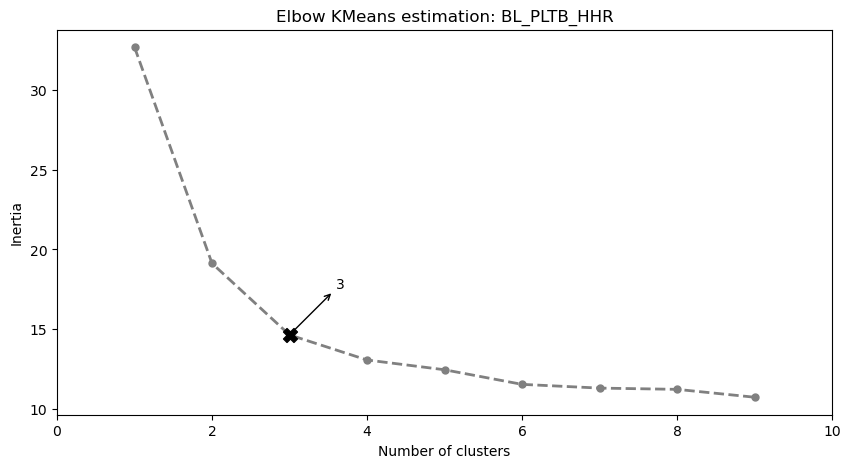

In [141]:
# ------------------------------------
# Elbow KMeans estimation
elbow_data = []
for n_clusters in tqdm(range(1,10,1),total=len(range(1,10,1)),desc='Elbow Method',position=0,leave=False):
            
    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=0,n_jobs=-1,metric='euclidean',n_init=2,max_iter_barycenter=10)
    y_pred = km.fit_predict(X_train)
    elbow_data.append((n_clusters, km.inertia_))
        
k_range = []
inertias = []
for elb in elbow_data:
    k_range.append(elb[0])
    inertias.append(elb[1])

# ------------------------------------    
# Elbow KMeans estimation
kn = KneeLocator(k_range, inertias,S=1, curve='convex', direction='decreasing')
elbow_point = kn.knee
            
# ------------------------------------
# Elbow KMeans plot
            
fig_elb, ax_elb = plt.subplots(figsize=(10,5))
            
ax_elb.annotate(str(elbow_point), xy=(elbow_point,inertias[k_range.index(elbow_point)]), xytext=(elbow_point+(elbow_point*0.2),inertias[k_range.index(elbow_point)]+(inertias[k_range.index(elbow_point)]*0.2)),arrowprops=dict(arrowstyle='<-',linewidth=1,color='black'))
ax_elb.scatter(elbow_point,inertias[k_range.index(elbow_point)],color='k', marker='X',s=100)
ax_elb.plot(k_range,inertias,color='grey', marker='o', linestyle='dashed',linewidth=2, markersize=5,zorder=-1)
ax_elb.set_title('Elbow KMeans estimation: '+PRF_df['network'].values[0]+'_'+PRF_df['station'].values[0]+'_'+PRF_df['channel'].values[0])
            
# Set ticks and labels on both sides of the y-axis
ax_elb.set_xlim(0,10)
ax_elb.set_ylabel('Inertia')
ax_elb.set_xlabel('Number of clusters')

os.makedirs(PPSD_OUTPUT+'FIGURES/',exist_ok=True)
fig_elb.savefig(PPSD_OUTPUT+'FIGURES/Elbow_'+PRF_df['network'].values[0]+'_'+PRF_df['station'].values[0]+'_'+PRF_df['channel'].values[0]+'_plot.png',pad_inches=0.02,dpi=200)


In [142]:
# ------------------------------------
# Euclidean k-means
           
n_clu = elbow_point
km = TimeSeriesKMeans(n_clusters=n_clu, verbose=False, random_state=0,n_jobs=-1,metric='euclidean',n_init=2,max_iter_barycenter=10)
y_pred = km.fit_predict(X_train)
            
PRF_df['k-means'] = y_pred

# ------------------------------------
# Compute the mean Silhouette Coefficient.
sscore = round(silhouette_score(X_train, PRF_df['k-means'], metric="euclidean"),2)
           
################################
##### CREATING THE FIGURE ######
################################
            
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3, n_clu,height_ratios=[5,2,0.1])
            
ax_prf = fig.add_subplot(gs[0, :])

# Locator: X & Y
majorY = MultipleLocator(20)
minorY = MultipleLocator(10)   

alpha = 0.75
lw = 0.1

# Plot PRF computed via both methods
for i in PRF_df.iterrows():
    name_PRF = i[1]['network']+'.'+i[1]['station']+'.'+i[1]['channel']		

    ax_prf.plot(i[1]['time'], i[1]['dataR'], color='k', lw=lw, alpha=alpha)
            
ax_prf.plot(PRF_df['time'].values[0],PRF_df['dataR'].values.mean(), color='r', lw=1,ls='--',label='mean')
ax_prf.text(0.1, 0.9,name_PRF,fontweight='bold', fontsize=15, ha='center',va='center',transform=ax_prf.transAxes)
ax_prf.text(0.9, 0.9,'SS: '+str(sscore)+'\n'+' (n:'+str(PRF_df.shape[0])+')',fontweight='bold', fontsize=12, ha='center',va='center',transform=ax_prf.transAxes)
            
ax_prf.set_ylabel('Amp')
ax_prf.set_xlabel('time after P (s)')
            
# Set limits for x-axes
ax_prf.set_xlim(-4,30)
ax_prf.set_ylim(-1,1)
            
# Set ticks and labels on both sides of the y-axis
ax_prf.spines['top'].set_linewidth(2)
ax_prf.spines['right'].set_linewidth(2)
ax_prf.spines['bottom'].set_linewidth(2)
ax_prf.spines['left'].set_linewidth(2)
ax_prf.yaxis.set_tick_params(which='both',width=2,labelright=True,left=True,right=True)
ax_prf.xaxis.set_tick_params(which='both',width=2,labeltop=False,labelbottom=True,bottom=True,top=True)
            
ax_prf.yaxis.set_major_locator(majorY)
ax_prf.yaxis.set_minor_locator(minorY)
ax_prf.legend(loc='lower left')

# ---------------------
theta = np.deg2rad(PRF_df['baz'])

# Histogram
n_bins = 36
counts, bin_edges = np.histogram(theta, bins=n_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Pega posição do eixo principal em coordenadas da figura
bbox = ax_prf.get_position()
x0, y0, width, height = bbox.x0, bbox.y0, bbox.width, bbox.height

# Define posição do inset como fração da posição do eixo principal
inset_width = 0.2 * width
inset_height = 0.2 * height
inset_x = x0 + 0.8 * width
inset_y = y0 + 0.15 * height

# Cria o eixo polar como inset
ax_inset = fig.add_axes([inset_x, inset_y, inset_width, inset_height], projection='polar')

# Plota o histograma no eixo polar
bars = ax_inset.bar(bin_centers, counts, width=(2 * np.pi / n_bins),
                    bottom=0.0, color='k', edgecolor='k', alpha=0.7)

# Ajustes visuais do inset
ax_inset.set_theta_zero_location('N')
ax_inset.set_theta_direction(-1)
ax_inset.set_yticklabels([])

# =======================================================================================================================================

# Get unique k-means
unique_k_means = sorted(PRF_df['k-means'].unique())

# ---------------------
# Adding k_means groups

for k in unique_k_means:
    ax = fig.add_subplot(gs[1, k])
            
    df_k = PRF_df[PRF_df['k-means'] == k]
          
    # Plot PRF computed via both methods
    for i in df_k.iterrows():
        ax.plot(i[1]['time'], i[1]['dataR'], color='k', lw=lw, alpha=alpha)

    ax.plot(df_k['time'].values[0],df_k['dataR'].values.mean(), color='r',ls='--',lw=1,alpha=0.5,label='mean')
    ax.text(0.5, 0.8,'Cluster %d' % (k)+'\n(n='+str(df_k.shape[0])+'['+str(round((df_k.shape[0]*100)/PRF_df.shape[0]))+'%])',fontweight='bold', fontsize=12, ha='center',transform=ax.transAxes)
            
    ax.set_xlim(-4,30)
    ax.set_ylim(-1,1)
            
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)  
            
    ax.yaxis.set_major_locator(majorY)
    ax.yaxis.set_minor_locator(minorY)
    ax.yaxis.set_tick_params(labelright=False,labelleft=False,left=True, right=True)  # Show labels on the right side
    ax.legend(loc='lower left')
            
    if k == unique_k_means[0]:
        ax.yaxis.set_tick_params(labelright=False,labelleft=True,left=True, right=True)  # Show labels on the right side
        ax.set_ylabel('Amp')

    if k == unique_k_means[-1]:
        ax.yaxis.set_tick_params(labelright=True,labelleft=False,left=True, right=True)  # Show labels on the right side
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('Amp')

    # ---------------------
    theta = np.deg2rad(df_k['baz'])
    
    # Histogram
    n_bins = 36
    counts, bin_edges = np.histogram(theta, bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Pega posição do eixo principal em coordenadas da figura
    bbox = ax.get_position()
    x0, y0, width, height = bbox.x0, bbox.y0, bbox.width, bbox.height
    
    # Define posição do inset como fração da posição do eixo principal
    inset_width = 0.3 * width
    inset_height = 0.3 * height
    inset_x = x0 + 0.7 * width
    inset_y = y0 + 0.15 * height
    
    # Cria o eixo polar como inset
    ax_inset = fig.add_axes([inset_x, inset_y, inset_width, inset_height], projection='polar')
    
    # Plota o histograma no eixo polar
    bars = ax_inset.bar(bin_centers, counts, width=(2 * np.pi / n_bins),
                        bottom=0.0, color='k', edgecolor='k', alpha=0.7)
    
    # Ajustes visuais do inset
    ax_inset.set_theta_zero_location('N')
    ax_inset.set_theta_direction(-1)
    ax_inset.set_yticklabels([])
    ax_inset.set_xticklabels([])

# -------------
# Saving FIGURE
os.makedirs(PPSD_OUTPUT+'FIGURES/',exist_ok=True)
fig.savefig(PPSD_OUTPUT+'FIGURES/'+i[1]['network']+'_'+i[1]['station']+'_KMeans.png',pad_inches=0.02,dpi=200)
        
# =======================================================================================================================================
# Saving 
# =======================================================================================================================================
os.makedirs(PPSD_OUTPUT+'FEATHER_FILES/'+i[1]['network']+'_'+i[1]['station'],exist_ok=True)
PRF_df.to_feather(PPSD_OUTPUT+'FEATHER_FILES/'+i[1]['network']+'_'+i[1]['station']+'/df_psd_'+i[1]['network']+'_'+i[1]['station']+'_KMeans.feather') 
        
# ----------------------------------------------------------------------------------------------------------
# Close the figure after savig 
# ----------------------------------------------------------------------------------------------------------                             
                                            
plt.close('all')

In [143]:
PRF_df

,filename,network,station,channel,baz,sampling_rate,dataRnorm,dataR,time,date,k-means
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,320,10.0,"[-0.7765470717980009, -0.7765470717566537, -0....","[1.3756263e-11, 3.7030132e-11, 9.769907e-11, 2...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-05-13 22:56:38,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,150,10.0,"[-0.873749907417944, -0.8737499073920489, -0.8...","[8.033043e-12, 2.1852948e-11, 5.8275614e-11, 1...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-05-21 00:22:24,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,191,10.0,"[-0.46662024221081, -0.466620242210774, -0.466...","[1.1920107e-14, 3.6428583e-14, 1.0892655e-13, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-06-05 12:04:07,0
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,155,10.0,"[-0.31721701857630014, -0.31721701856499485, -...","[4.9271793e-12, 1.350986e-11, 3.6332003e-11, 9...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-07-15 13:32:30,0
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,151,10.0,"[-0.8195385127747274, -0.8195385127596817, -0....","[4.8331968e-12, 1.3102212e-11, 3.4825476e-11, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-09-03 04:54:56,1
...,...,...,...,...,...,...,...,...,...,...,...
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,156,10.0,"[-0.7211831527485231, -0.7211831527277761, -0....","[7.123384e-12, 1.9177316e-11, 5.0610606e-11, 1...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-11-02 14:24:27,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,315,10.0,"[-0.658570931450327, -0.6585709314138197, -0.6...","[1.3004836e-11, 3.5016136e-11, 9.241039e-11, 2...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-02-16 07:21:59,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,193,10.0,"[-0.7269363501854029, -0.7269363501798336, -0....","[1.8392531e-12, 5.064263e-12, 1.36791784e-11, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-02-21 23:35:43,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,318,10.0,"[-0.6841946125136908, -0.6841946125003209, -0....","[4.536833e-12, 1.24753905e-11, 3.361972e-11, 8...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-01-06 16:34:18,1


In [144]:
PRF_df_selected = PRF_df[PRF_df['k-means'] == 1]

In [145]:
PRF_df_selected

,filename,network,station,channel,baz,sampling_rate,dataRnorm,dataR,time,date,k-means
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,320,10.0,"[-0.7765470717980009, -0.7765470717566537, -0....","[1.3756263e-11, 3.7030132e-11, 9.769907e-11, 2...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-05-13 22:56:38,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,150,10.0,"[-0.873749907417944, -0.8737499073920489, -0.8...","[8.033043e-12, 2.1852948e-11, 5.8275614e-11, 1...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-05-21 00:22:24,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,151,10.0,"[-0.8195385127747274, -0.8195385127596817, -0....","[4.8331968e-12, 1.3102212e-11, 3.4825476e-11, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-09-03 04:54:56,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,313,10.0,"[-0.7465851060786844, -0.7465851060372223, -0....","[1.4034939e-11, 3.7773916e-11, 9.964809e-11, 2...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-11-17 02:04:27,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,311,10.0,"[-0.7421202057743177, -0.742120205756059, -0.7...","[6.117624e-12, 1.6598445e-11, 4.415243e-11, 1....","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2011-12-11 01:57:57,1
...,...,...,...,...,...,...,...,...,...,...,...
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,156,10.0,"[-0.7211831527485231, -0.7211831527277761, -0....","[7.123384e-12, 1.9177316e-11, 5.0610606e-11, 1...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-11-02 14:24:27,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,315,10.0,"[-0.658570931450327, -0.6585709314138197, -0.6...","[1.3004836e-11, 3.5016136e-11, 9.241039e-11, 2...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-02-16 07:21:59,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,193,10.0,"[-0.7269363501854029, -0.7269363501798336, -0....","[1.8392531e-12, 5.064263e-12, 1.36791784e-11, ...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-02-21 23:35:43,1
0,/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOU...,BL,PLTB,HHR,318,10.0,"[-0.6841946125136908, -0.6841946125003209, -0....","[4.536833e-12, 1.24753905e-11, 3.361972e-11, 8...","[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....",2022-01-06 16:34:18,1


In [146]:
for i in PRF_df_selected.iterrows():
    os.makedirs('/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOUTH_AMERICA/OUTPUT/RF_HK/'+i[1]['network']+'.'+i[1]['station']+'/',exist_ok=True)
    shutil.copy2(i[1]['filename'],'/home/sysop/dados_posdoc/INVERSAO_CONJUNTA_SOUTH_AMERICA/OUTPUT/RF_HK/'+i[1]['network']+'.'+i[1]['station']+'/'+i[1]['filename'].split('/')[-1])